In [1]:
# imports
import pandas as pd
import os, ipdb, re
import random, evaluate
import string
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from datasets import DatasetDict, Dataset, load_dataset
import wandb
import ast
import re, os
import subprocess

from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

/nfs/home/kabenamualus/anaconda3/envs/tdm/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# # dataset_path = "../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_ALL_TEMPLATE/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_LONG/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_DOCTEAT/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"

# dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
# dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

In [3]:
def calculate_fuzz_ratio(text1, text2):
    return fuzz.ratio(str(text1).strip().lower(), str(text2).strip().lower())

def view_leaderboard_distribution(dfs):

    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_train = dfs['train'].copy()
    dfs_validation = dfs['validation'].copy()

    dfs_train['leaderboard'] = dfs_train.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_train = dfs_train['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=140)
    plt.title('Train Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_validation['leaderboard'] = dfs_validation.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_validation = dfs_validation['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_validation, labels=counts_validation.index, autopct='%1.1f%%', startangle=140)
    plt.title('Validation Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_zeroshot['leaderboard'] = dfs_zeroshot.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts = dfs_zeroshot['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Zeroshot Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    
def verify_data_integrity_old(dfs):

    zeroshot_paper_in_train = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['train'].id.to_list():
            zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['validation'].id.to_list():
            zeroshot_paper_in_validation += 1 

    train_paper_in_validation = 0
    for paper in dfs['train'].id.unique():
        if paper in dfs['validation'].id.to_list():
            train_paper_in_validation += 1   
        
    validation_paper_in_zeroshot = 0
    for paper in dfs['validation'].id.unique():
        if paper in dfs['zeroshot'].id.to_list():
            validation_paper_in_zeroshot += 1     
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"train_paper_in_validation: {train_paper_in_validation}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def verify_data_integrity(dfs, include_no_lb=True):

    zeroshot_paper_in_train = 0
    dfs_train = dfs['train'].copy()
    dfs_train.drop_duplicates(subset='id', inplace=True)
    dfs_validation = dfs['validation'].copy()
    dfs_validation.drop_duplicates(subset='id', inplace=True)
    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_zeroshot.drop_duplicates(subset='id', inplace=True)
    
    records_zero_train = dfs_zeroshot.to_dict("records")    
    for row in records_zero_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                zeroshot_paper_in_train += 1
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    records_zero_val = dfs_zeroshot.to_dict("records")
    for row in records_zero_val:
        if include_no_lb:
            if row['id'] in dfs_validation['id'].to_list():
                zeroshot_paper_in_validation += 1 
        else:
            if row['id'] in dfs_validation['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_validation += 1 

    validation_paper_in_train = 0
    records_val_train = dfs_validation.to_dict("records")
    for row in records_val_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                validation_paper_in_train += 1   
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_train += 1   
        
    validation_paper_in_zeroshot = 0
    records_train_zero = dfs_validation.to_dict("records")
    for row in records_train_zero:
            
        if include_no_lb:
            if row['id'] in dfs_zeroshot['id'].to_list():
                validation_paper_in_zeroshot += 1     
        else:
            if row['id'] in dfs_zeroshot['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_zeroshot += 1   
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"validation_paper_in_train: {validation_paper_in_train}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def remove_data_leakage_old(dfs, source, target, THRESHOLD=90):
    papers_to_drop = []
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    source_records = dfs[source].to_dict("records")

    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        
        for leaderboard_source in source_tdms:
            
            if to_drop_paper_found:
                break
            
            source_task = leaderboard_source["LEADERBOARD"]["Task"]
            source_dataset = leaderboard_source["LEADERBOARD"]["Dataset"]
            source_metric = leaderboard_source["LEADERBOARD"]["Metric"]
            source_score = leaderboard_source["LEADERBOARD"]["Score"]
 
            dfs[target].drop_duplicates(subset='id', inplace=True)
            
            target_records = dfs[target].to_dict("records")

            for target_row in target_records:
                
                if to_drop_paper_found:
                        break    
                
                target_paper_id = target_row["id"]
                target_tdms = target_row["answer"]
                
                if target_tdms == "unanswerable" or target_tdms == "missed":
                    # ipdb.set_trace()
                    continue 
                
                target_tdms = ast.literal_eval(target_row["answer"])
                
                
                for leaderboard_target in target_tdms:
                    target_task = leaderboard_target["LEADERBOARD"]["Task"]
                    target_dataset = leaderboard_target["LEADERBOARD"]["Dataset"]
                    target_metric = leaderboard_target["LEADERBOARD"]["Metric"]
                    target_score = leaderboard_target["LEADERBOARD"]["Score"]
                    
                    # A) Exact 
                    if (source_task == target_task and source_dataset == target_dataset and source_metric == target_metric) or (target_paper_id == source_paper_id):
                        if source_paper_id not in papers_to_drop:
                            papers_to_drop.append(source_paper_id)
                        to_drop_paper_found = True 
                        break
    
                    # # B) Partial  or # A) Exact 
                    # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
                    #     if paper_id not in papers_to_drop:
                    #         papers_to_drop.append(paper_id)
                    #         # ipdb.set_trace()
                    #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage_id(dfs, source, target, THRESHOLD=90):
    papers_to_drop = set()
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    records = dfs[source].to_dict("records")

    for row in tqdm(records, total=len(records)):
        to_drop_paper_found = False 
        source_paper_id = row["id"]
        
        dfs[target].drop_duplicates(subset='id', inplace=True)
        target_records = dfs[target].to_dict("records")

        for row_target in target_records:  
            
            target_paper_id = row_target["id"]
            
            # A) Exact 
            if (target_paper_id == source_paper_id):
                papers_to_drop.add(source_paper_id)
                to_drop_paper_found = True 
                break
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage(dfs, source, target, THRESHOLD=90):
    papers_to_drop = {"id": set(), "tdm":set()}
    missed_parsing_zero = 0
    
    dfs_target = dfs[target].drop_duplicates(subset='id')
    unique_paper_id_target = dfs_target.id.unique()
    lists_target = [ast.literal_eval(lb) for lb in dfs_target[dfs_target.leaderboard =="lb"].answer.to_list()]
    # Flatten the list of lists
    flattened_list_target = [item for sublist in lists_target for item in sublist]
    # Extract unique tuples
    unique_tuples_target = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in flattened_list_target}


    dfs_source = dfs[source].drop_duplicates(subset='id')
    source_records = dfs_source.to_dict("records")
    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_paper_id in unique_paper_id_target:
            papers_to_drop["id"].add(source_paper_id)
            continue     
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        # Extract unique tuples
        unique_tuples_source = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in source_tdms} 
        
        is_contained = unique_tuples_source.issubset(unique_tuples_target)
    
        if is_contained:
            papers_to_drop["tdm"].add(source_paper_id)
            
      
        
        # # B) Partial  or # A) Exact 
        # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
        #     if paper_id not in papers_to_drop:
        #         papers_to_drop.append(paper_id)
        #         # ipdb.set_trace()
        #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target} Title ID: {len(papers_to_drop['id'])}") 
    print(f"Lenght papers_to_drop in {source} based on {target} TDM Match: {len(papers_to_drop['tdm'])}")   

    print(f"Lenght papers from {source} with lb: {len(dfs_source[dfs_source['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {source} with no_lb: {len(dfs_source[dfs_source['leaderboard']=='no_lb'])}") 
    print(f"Lenght papers from {target} with lb: {len(dfs_target[dfs_target['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {target} with no_lb: {len(dfs_target[dfs_target['leaderboard']=='no_lb'])}") 
    
    
    return papers_to_drop

## REC

In [4]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")

In [5]:
dfs['train'].describe()

,id,prompt,answer,template,leaderboard
count,92910,92910,92910,92910,92910
unique,12388,92545,7976,15,2
top,1704.06326v2.pdf,Title:\t\n\nAbstract:\t\n\n[image]\n\nTry to a...,unanswerable,drop_7,lb
freq,14,17,33072,6198,59838


In [6]:
dfs['validation'].describe()

,id,prompt,answer,template,leaderboard
count,12315,12315,12315,12315,12315
unique,1642,12314,994,15,2
top,1101.0552.pdf,Title:\tA Sample ACM SIG Proceedings Paper in ...,unanswerable,drop_7,lb
freq,14,2,4902,822,7413


In [7]:
dfs['zeroshot'].describe()

,id,prompt,answer,template,leaderboard
count,9000,9000,9000,9000,9000
unique,1200,8984,653,15,2
top,1812.01936v1.pdf,Read this and answer the question. If the ques...,unanswerable,drop_7,lb
freq,14,3,4122,601,4878


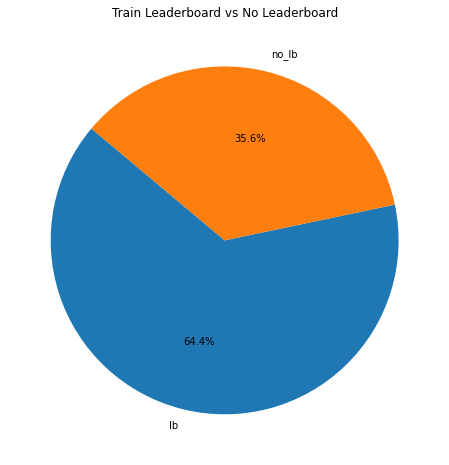

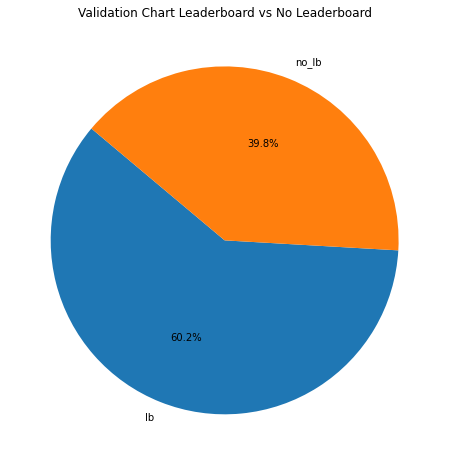

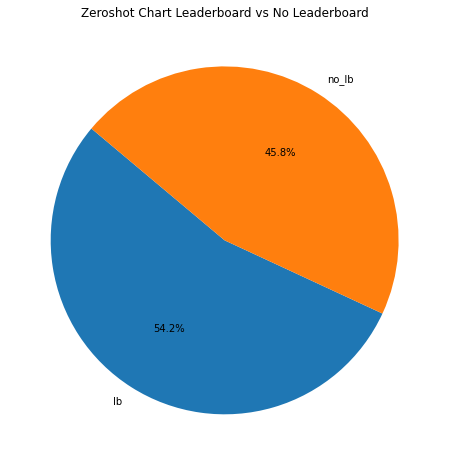

In [8]:
view_leaderboard_distribution(dfs)

In [9]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 1200/1200 [00:00<00:00, 7165.36it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 592
Lenght papers_to_drop in zeroshot based on train TDM Match: 50
Lenght papers from zeroshot with lb: 652
Lenght papers from zeroshot with no_lb: 548
Lenght papers from train with lb: 7987
Lenght papers from train with no_lb: 4401

validation



100%|██████████| 1642/1642 [00:00<00:00, 5530.71it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 753
Lenght papers from validation with lb: 994
Lenght papers from validation with no_lb: 648
Lenght papers from train with lb: 7987
Lenght papers from train with no_lb: 4401


In [10]:
dfs['zeroshot'].describe()

,id,prompt,answer,template,leaderboard
count,9000,9000,9000,9000,9000
unique,1200,8984,653,15,2
top,1812.01936v1.pdf,Read this and answer the question. If the ques...,unanswerable,drop_7,lb
freq,14,3,4122,601,4878


In [11]:
print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

len(dfs['zeroshot']): 9000
len(dfs['validation']): 12315
len(dfs['zeroshot']): 4580
len(dfs['validation']): 12315


In [12]:
dfs['zeroshot'].describe()

,id,prompt,answer,template,leaderboard
count,4580,4580,4580,4580,4580
unique,608,4572,61,15,2
top,1409.8098.pdf,Answer based on context:\n\nTitle:\tA Sample A...,unanswerable,squad_8,no_lb
freq,13,2,4122,323,4122


In [13]:
# In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
# At least one of the leaderboard was not seen at training time 
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

print("\nvalidation\n")
# in validation this means paper to keep as part of few shot 
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 608/608 [00:00<00:00, 7727.03it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 50
Lenght papers from zeroshot with lb: 60
Lenght papers from zeroshot with no_lb: 548
Lenght papers from train with lb: 7987
Lenght papers from train with no_lb: 4401

validation



100%|██████████| 1642/1642 [00:00<00:00, 5540.06it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 753
Lenght papers from validation with lb: 994
Lenght papers from validation with no_lb: 648
Lenght papers from train with lb: 7987
Lenght papers from train with no_lb: 4401


In [14]:
zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
print(f"len(zeroshot_concat): {len(zeroshot_concat)}")
# zeroshot_concat = dfs['zeroshot']
# print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
print(f"len(validation_concat): {len(validation_concat)}")

len(zeroshot_concat): 6394
len(validation_concat): 12703


In [15]:
# Filtering the DataFrame
dfs['zeroshot'] = zeroshot_concat.copy()

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]

dfs['zeroshot'].describe()

,id,prompt,answer,template,leaderboard
count,6006,6006,6006,6006,6006
unique,789,5968,242,15,2
top,1810.11408v2.pdf,Title:\tRecognition of Instrument-Tissue Inter...,unanswerable,squad_8,no_lb
freq,19,2,4122,420,4122


In [16]:
# Filtering the DataFrame
dfs['validation'] = validation_concat.copy()
# I want to keep all the no leaderboard papers in validation 
dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]

dfs['validation'].describe()

,id,prompt,answer,template,leaderboard
count,10889,10889,10889,10889,10889
unique,1401,10697,753,15,2
top,2006.13164v3.pdf,Read this: Title:\tLearning to Compose Dynamic...,unanswerable,squad_1,lb
freq,21,2,4902,739,5987


In [17]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 789/789 [00:00<00:00, 6597.82it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 241
Lenght papers from zeroshot with no_lb: 548
Lenght papers from train with lb: 7987
Lenght papers from train with no_lb: 4401

validation



100%|██████████| 1401/1401 [00:00<00:00, 5838.04it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 753
Lenght papers from validation with lb: 753
Lenght papers from validation with no_lb: 648
Lenght papers from train with lb: 7987
Lenght papers from train with no_lb: 4401


In [18]:
dfs['train'].tail()

,id,prompt,answer,template,leaderboard
92905,1807.01511v1.pdf,Context: Title:\tDeep Autoencoder for Combined...,[{'LEADERBOARD': {'Task': '3D Human Pose Estim...,drop_7,lb
92906,1907.05091v1.pdf,Context: Title:\tEfficient Semantic Scene Comp...,[{'LEADERBOARD': {'Task': '3D Semantic Scene C...,drop_7,lb
92907,1410.1282.pdf,Context: Title:\tCapacity Estimation for Vehic...,unanswerable,drop_7,no_lb
92908,1605.01627.pdf,Context: Title:\tA Sensing Contribution-based ...,unanswerable,drop_7,no_lb
92909,1312.7217.pdf,Context: Title:\tDistributed and Parallel Algo...,unanswerable,drop_7,no_lb


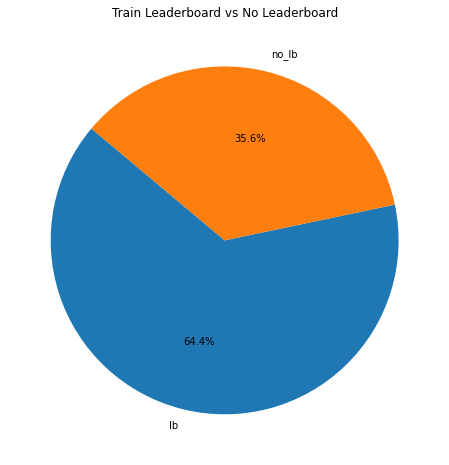

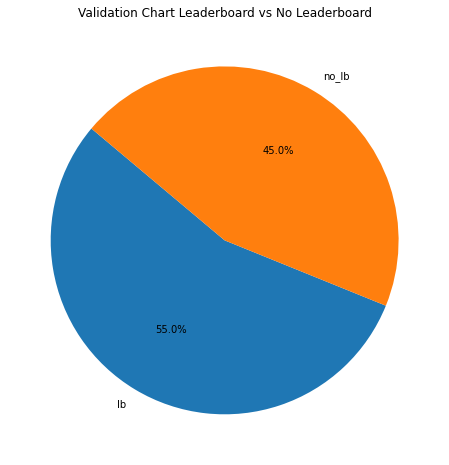

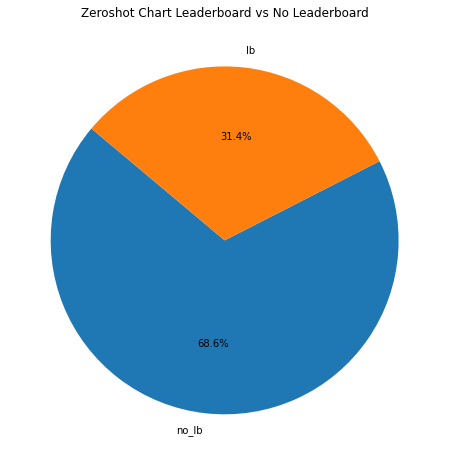

In [19]:
view_leaderboard_distribution(dfs)

In [20]:
verify_data_integrity(dfs, include_no_lb=False)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


In [21]:
dfs['zeroshot'].describe()

,id,prompt,answer,template,leaderboard
count,6006,6006,6006,6006,6006
unique,789,5968,242,15,2
top,1810.11408v2.pdf,Title:\tRecognition of Instrument-Tissue Inter...,unanswerable,squad_8,no_lb
freq,19,2,4122,420,4122


In [22]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_REC_TDMS_50_PERCENT_TEMPLATES")
# LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT

Saving the dataset (0/3 shards):   0%|          | 0/92910 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10889 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6006 [00:00<?, ? examples/s]

## LONG

In [23]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_LONG/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")

In [24]:
dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,88535,88535,88535,88535,88535
unique,11807,88382,7733,15,2
top,1302.6454.pdf,Title:\t\n\nAbstract:\t\n\n [caption={Demon...,unanswerable,squad_2,lb
freq,14,4,30569,5934,57966


In [25]:
dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,11725,11725,11725,11725,11725
unique,1565,11723,961,15,2
top,1905.09272v3.pdf,Title:\tA Sample ACM SIG Proceedings Paper in ...,unanswerable,squad_3,lb
freq,14,2,4565,792,7160


In [26]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,8504,8504,8504,8504,8504
unique,1137,8496,631,15,2
top,1812.01936v1.pdf,Title:\tA Sample ACM SIG Proceedings Paper in ...,unanswerable,squad_6,lb
freq,14,2,3804,575,4700


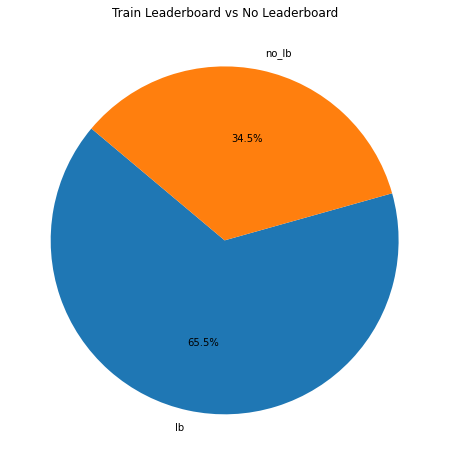

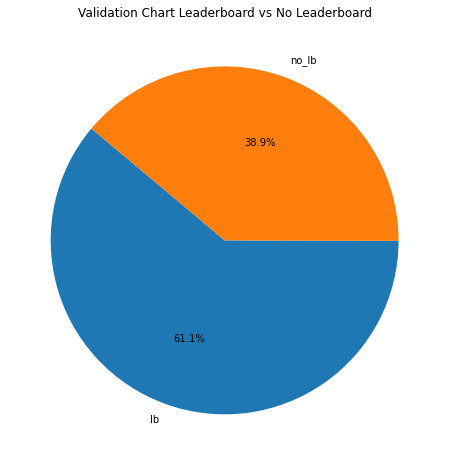

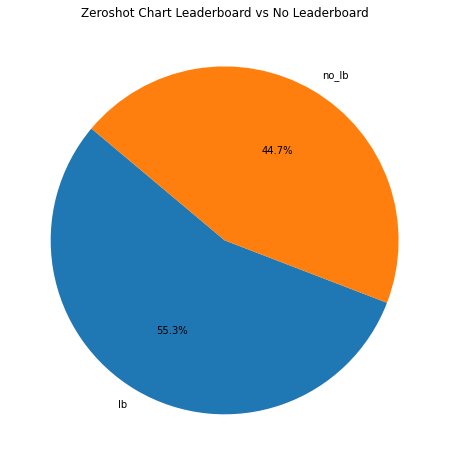

In [27]:
view_leaderboard_distribution(dfs)

In [28]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 1137/1137 [00:00<00:00, 7536.21it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 572
Lenght papers_to_drop in zeroshot based on train TDM Match: 48
Lenght papers from zeroshot with lb: 630
Lenght papers from zeroshot with no_lb: 507
Lenght papers from train with lb: 7744
Lenght papers from train with no_lb: 4063

validation



100%|██████████| 1565/1565 [00:00<00:00, 5752.35it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 722
Lenght papers from validation with lb: 961
Lenght papers from validation with no_lb: 604
Lenght papers from train with lb: 7744
Lenght papers from train with no_lb: 4063


In [29]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,8504,8504,8504,8504,8504
unique,1137,8496,631,15,2
top,1812.01936v1.pdf,Title:\tA Sample ACM SIG Proceedings Paper in ...,unanswerable,squad_6,lb
freq,14,2,3804,575,4700


In [30]:
print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

len(dfs['zeroshot']): 8504
len(dfs['validation']): 11725
len(dfs['zeroshot']): 4245
len(dfs['validation']): 11725


In [31]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,4245,4245,4245,4245,4245
unique,565,4237,59,15,2
top,1409.8098.pdf,Read this and answer the question. If the ques...,unanswerable,drop_6,no_lb
freq,13,2,3804,297,3804


In [32]:
# In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
# At least one of the leaderboard was not seen at training time 
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

print("\nvalidation\n")
# in validation this means paper to keep as part of few shot 
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 565/565 [00:00<00:00, 8214.40it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 48
Lenght papers from zeroshot with lb: 58
Lenght papers from zeroshot with no_lb: 507
Lenght papers from train with lb: 7744
Lenght papers from train with no_lb: 4063

validation



100%|██████████| 1565/1565 [00:00<00:00, 5856.92it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 722
Lenght papers from validation with lb: 961
Lenght papers from validation with no_lb: 604
Lenght papers from train with lb: 7744
Lenght papers from train with no_lb: 4063


In [33]:
zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
print(f"len(zeroshot_concat): {len(zeroshot_concat)}")
# zeroshot_concat = dfs['zeroshot']
# print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
print(f"len(validation_concat): {len(validation_concat)}")

len(zeroshot_concat): 6045
len(validation_concat): 12096


In [34]:
# Filtering the DataFrame
dfs['zeroshot'] = zeroshot_concat.copy()

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]

dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,5674,5674,5674,5674,5674
unique,746,5636,240,15,2
top,1810.11408v2.pdf,Title:\tESRGAN: Enhanced Super-Resolution Gene...,unanswerable,squad_3,no_lb
freq,19,2,3804,399,3804


In [35]:
# Filtering the DataFrame
dfs['validation'] = validation_concat.copy()
# I want to keep all the no leaderboard papers in validation 
dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]

dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,10296,10296,10296,10296,10296
unique,1326,10110,722,15,2
top,2006.13164v3.pdf,Title:\tSoftmax Splatting for Video Frame Inte...,unanswerable,drop_5,lb
freq,21,2,4565,697,5731


In [36]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 746/746 [00:00<00:00, 3506.99it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 239
Lenght papers from zeroshot with no_lb: 507
Lenght papers from train with lb: 7744
Lenght papers from train with no_lb: 4063

validation



100%|██████████| 1326/1326 [00:00<00:00, 6065.34it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 722
Lenght papers from validation with lb: 722
Lenght papers from validation with no_lb: 604
Lenght papers from train with lb: 7744
Lenght papers from train with no_lb: 4063


In [37]:
dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

In [38]:
dfs['train'].tail()

,id,prompt,answer,template,prompt lenght,leaderboard
88530,1909.09314v2.pdf,Context: Title:\t\n\nAbstract:\t\n\nExperiment...,"[{'LEADERBOARD': {'Task': 'MuJoCo Games', 'Dat...",drop_7,1297,lb
88531,1907.05091v1.pdf,Context: Title:\tEfficient Semantic Scene Comp...,[{'LEADERBOARD': {'Task': '3D Semantic Scene C...,drop_7,4925,lb
88532,1410.1282.pdf,Context: Title:\tCapacity Estimation for Vehic...,unanswerable,drop_7,8442,no_lb
88533,1605.01627.pdf,Context: Title:\tA Sensing Contribution-based ...,unanswerable,drop_7,7466,no_lb
88534,1312.7217.pdf,Context: Title:\tDistributed and Parallel Algo...,unanswerable,drop_7,11583,no_lb


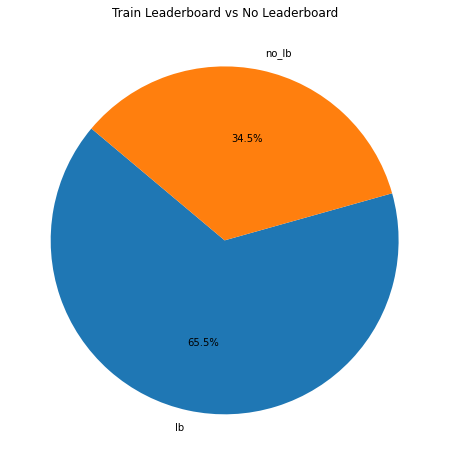

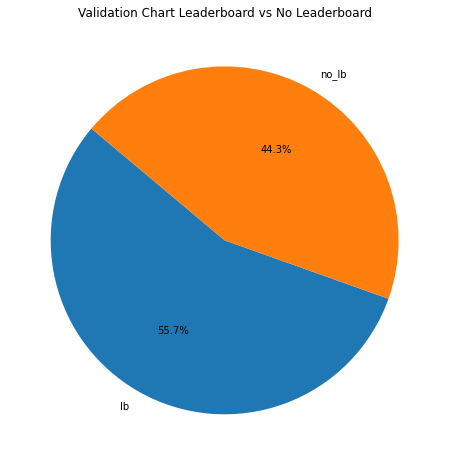

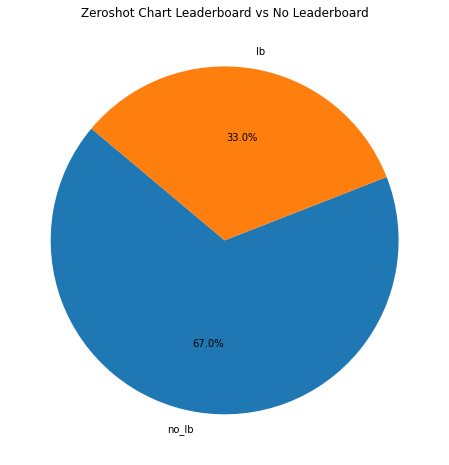

In [39]:
view_leaderboard_distribution(dfs)

In [40]:
verify_data_integrity(dfs, include_no_lb=False)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


In [41]:
dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,5674,5674,5674,5674,5674
unique,746,5636,240,15,2
top,1810.11408v2.pdf,Title:\tESRGAN: Enhanced Super-Resolution Gene...,unanswerable,squad_3,no_lb
freq,19,2,3804,399,3804


In [42]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_LONG_TDMS_50_PERCENT_TEMPLATES")

Saving the dataset (0/8 shards):   0%|          | 0/88535 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10296 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5674 [00:00<?, ? examples/s]

## DOCTEAT

In [43]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_DOCTEAT/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")

In [44]:
dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,75396,75396,75396,75396,75396
unique,10058,75181,7016,15,2
top,1603.00856v3.pdf,Author Guidelines for ECCV Submission The abst...,unanswerable,drop_6,lb
freq,14,6,22800,5068,52596


In [45]:
dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,10103,10103,10103,10103,10103
unique,1347,10102,903,15,2
top,1101.0552.pdf,Context: Segmentation Transformer: Object-Cont...,unanswerable,squad_3,lb
freq,14,2,3355,690,6748


In [46]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,6903,6903,6903,6903,6903
unique,926,6903,574,15,2
top,1812.01936v1.pdf,Very Deep Transformers for Neural Machine Tran...,unanswerable,drop_5,lb
freq,14,1,2622,471,4281


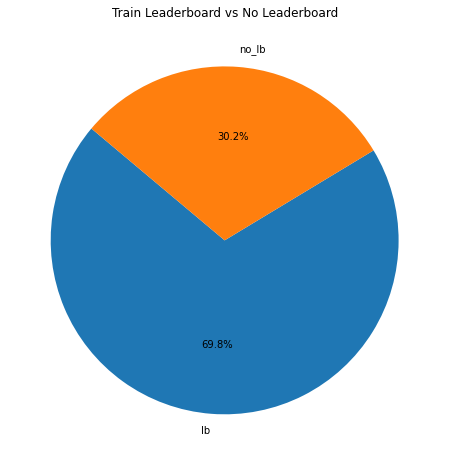

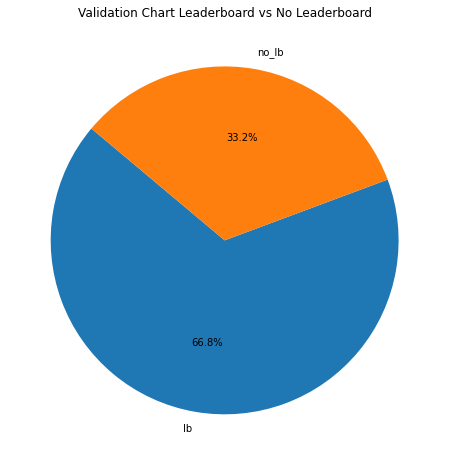

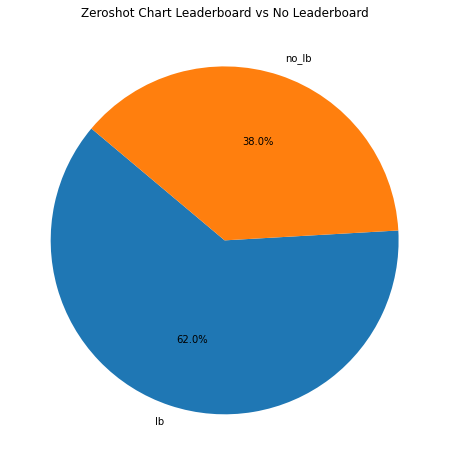

In [47]:
view_leaderboard_distribution(dfs)

In [48]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 926/926 [00:00<00:00, 4496.97it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 6527.10it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [49]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,6903,6903,6903,6903,6903
unique,926,6903,574,15,2
top,1812.01936v1.pdf,Very Deep Transformers for Neural Machine Tran...,unanswerable,drop_5,lb
freq,14,1,2622,471,4281


In [50]:
print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

len(dfs['zeroshot']): 6903
len(dfs['validation']): 10103
len(dfs['zeroshot']): 3043
len(dfs['validation']): 10103


In [51]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,3043,3043,3043,3043,3043
unique,408,3043,56,15,2
top,1409.8098.pdf,Edge-b-coloring Trees Partially supported b...,unanswerable,drop_6,no_lb
freq,13,1,2622,218,2622


In [52]:
# In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
# At least one of the leaderboard was not seen at training time 
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

print("\nvalidation\n")
# in validation this means paper to keep as part of few shot 
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 408/408 [00:00<00:00, 9465.39it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 6501.11it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [53]:
zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
print(f"len(zeroshot_concat): {len(zeroshot_concat)}")
# zeroshot_concat = dfs['zeroshot']
# print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
print(f"len(validation_concat): {len(validation_concat)}")

len(zeroshot_concat): 4871
len(validation_concat): 10442


In [54]:
# Filtering the DataFrame
dfs['zeroshot'] = zeroshot_concat.copy()

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]

dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,4532,4532,4532,4532,4532
unique,595,4495,243,15,2
top,1810.11408v2.pdf,Read this: Anytime Stereo Image Depth Estimati...,unanswerable,drop_3,no_lb
freq,19,2,2622,322,2622


In [55]:
# Filtering the DataFrame
dfs['validation'] = validation_concat.copy()
# I want to keep all the no leaderboard papers in validation 
dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]

dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,8614,8614,8614,8614,8614
unique,1105,8442,661,15,2
top,2007.07875v2.pdf,INTERRUPTED AND CASCADED PERMUTATION INVARIANT...,unanswerable,drop_5,lb
freq,21,2,3355,586,5259


In [56]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 595/595 [00:00<00:00, 7615.12it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 6959.35it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [57]:
dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

In [58]:
dfs['train'].tail()

,id,prompt,answer,template,prompt lenght,leaderboard
75391,1909.09314v2.pdf,"Context: In this section, we seek to investiga...","[{'LEADERBOARD': {'Task': 'MuJoCo Games', 'Dat...",drop_7,230,lb
75392,1907.05091v1.pdf,Context: Efficient Semantic Scene Completion N...,[{'LEADERBOARD': {'Task': '3D Semantic Scene C...,drop_7,366,lb
75393,1410.1282.pdf,Context: Capacity Estimation for Vehicle-to-Gr...,unanswerable,drop_7,232,no_lb
75394,1605.01627.pdf,Context: A Sensing Contribution-based Two-laye...,unanswerable,drop_7,238,no_lb
75395,1312.7217.pdf,Context: Distributed and Parallel Algorithms f...,unanswerable,drop_7,123,no_lb


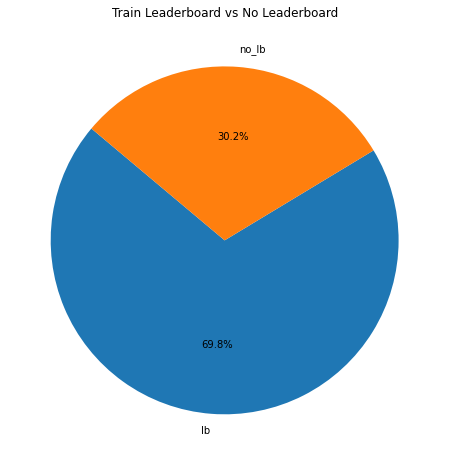

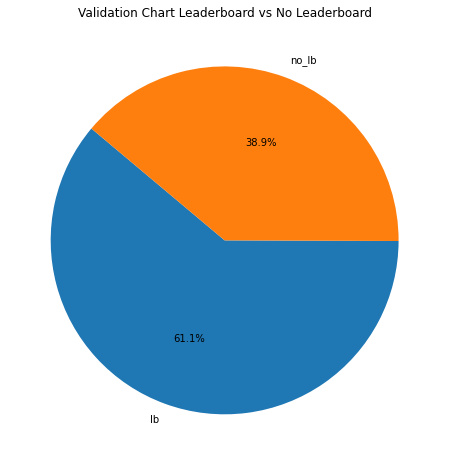

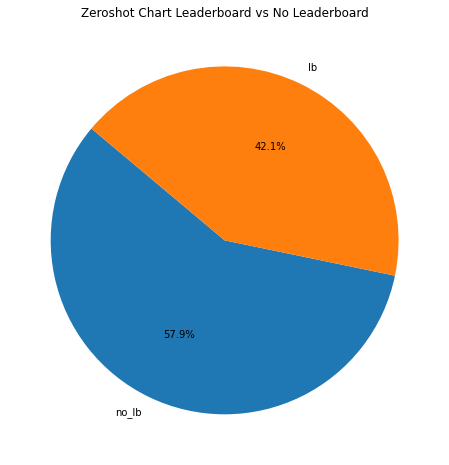

In [59]:
view_leaderboard_distribution(dfs)

In [60]:
verify_data_integrity(dfs, include_no_lb=False)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


In [61]:
dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,4532,4532,4532,4532,4532
unique,595,4495,243,15,2
top,1810.11408v2.pdf,Read this: Anytime Stereo Image Depth Estimati...,unanswerable,drop_3,no_lb
freq,19,2,2622,322,2622


In [62]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_DOCTEAT_TDMS_50_PERCENT_TEMPLATES")


Saving the dataset (0/1 shards):   0%|          | 0/75396 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8614 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4532 [00:00<?, ? examples/s]